# 코드 수정 2023 8월 2일 ~

> 이유:겨울 프로젝트 당시에 결과를 빨리 내려고 코드를 너무 난잡하게 작성

# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

import lightgbm
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [19]:
# 카운트 
def count_frequency(my_list):
    
    count = {}
    
    for item in my_list:
        count[item] = count.get(item, 0) + 1
        
    return count

# **load model**

In [26]:
# 저장 모델 불러오기

#lgbm   
loaded_model = joblib.load('C:\\Users\\USER\\Desktop\\논문작성용 데이터및 모델\\논문작성용 데이터및 모델\\LGBM.pkl')

#lgbm_bopt
model_bopt = joblib.load('C:\\Users\\USER\\Desktop\\논문작성용 데이터및 모델\\논문작성용 데이터및 모델\\lgbm_bopt.pkl')

In [19]:
cnc = pd.read_csv('C:\\Users\\USER\\Desktop\\논문작성용 데이터및 모델\\논문작성용 데이터및 모델\\CNC.csv', index_col=0)

In [20]:
cnc

,spindle load,actual RPM,actual Feedrate,C1,width,try,line,num
61,0,4000,600,4.2873,3.200,1,0,1.0
62,0,4000,600,4.2935,3.200,1,0,1.0
63,0,4000,600,4.3029,3.200,1,0,1.0
64,0,4000,600,4.3029,3.200,1,0,1.0
65,0,4000,600,4.3060,3.200,1,0,1.0
...,...,...,...,...,...,...,...,...
2012,0,3999,1500,4.2888,3.114,10,0,27.0
2013,0,4000,1500,4.2982,3.114,10,0,27.0
2014,0,4000,1500,4.3091,3.114,10,0,27.0
2015,0,3999,1500,4.3216,3.114,10,0,27.0


# 전처리

In [103]:
# 폴더 지정
  
forders2_1 = []    
file2_1 = os.listdir('C:/Users/default.DESKTOP-VR7UF4O/Desktop/feed 50~120 (전류 확인)/feed 50 ~ 120 2 try')
for i in range(len(file2_1)):
  name = 'C:/Users/default.DESKTOP-VR7UF4O/Desktop/feed 50~120 (전류 확인)/feed 50 ~ 120 2 try/'+file2_1[i]
  forders2_1.append(name)


In [102]:
df_10 = pd.DataFrame()

forders = forders_o

for i in range(0,len(forders)):
  forder = os.listdir(forders[i])

  for j in range(0,len(forder)):
    if forder[j].split('.')[1] == 'csv':
        
        file = forders[i]+'/'+forder[j]
        
        df_file = pd.read_csv(file,skiprows=[0])

    df_z = df_file[df_file[' z'] == -1] # z값 -1인 데이터만
    
    drop = ['hh:mm:ss:ms', ' Sampling Interval', ' Block No', ' G-code', ' G80',
          ' M-code', ' Start', ' mode', ' z', ' a', ' b', ' c',
          ' command RPM', ' command Feedrate', ' actLoad',
          ' Ref_upper', ' Ref_lower', ' PLCFOV',
          ' cmdFOV', ' cmdSOV', ' userASCOn', ' userAFCon',
          ' TWon', ' C2', ' C3', ' C4', ' A1', ' A1h', ' A1 chatter',
          ' A2', ' A2H', ' A2 chatter'] # 제거할 열들(z는 확인 결과 전부 -1)
    
    df_d = df_z.drop(drop,axis = 1) # 필요없는 열 제거

    df_l = df_d[df_d[' C1'] > 1] # 확인결과 C1이 1보다 작은경우 이상치로 보여 제거
    
    
    # 경로간 절살폭 계산
    df_l['width'] = np.nan
    df_l['width'].iloc[0] = 8 + df_l[' y'].iloc[0]    
    
    # 동일 공구로 가공 시행 횟수
    df_l['try'] = j+1
    
    # 공구 방향 전환 
    df_l['line'] = 2
    df_l['line'].iloc[0] = 0

    for m in range(1, len(df_l)): # 경로간 절살폭 계산 

      if df_l[' y'].iloc[m] - df_l[' y'].iloc[m-1] == 0:
        df_l['width'].iloc[m] = df_l['width'].iloc[m-1]
      
      else:
        df_l['width'].iloc[m] = df_l[' y'].iloc[m]-df_l[' y'].iloc[m-1] #파일 새로 시작될때 폭 달라지는거 신경 안 쓰고 막 했음
  
    for n in range(1, len(df_l)): # 공구 방향 전환 
      if df_l[' x'].iloc[n] > df_l[' x'].iloc[n-1]:
        df_l['line'].iloc[n] = 0
      
      elif df_l[' x'].iloc[n] < df_l[' x'].iloc[n-1]:
        df_l['line'].iloc[n] = 1   

    for u in range(1, len(df_l)):  # 공구 방향 전환   
        
      if df_l['line'].iloc[u]==2:
        df_l['line'].iloc[u] = df_l['line'].iloc[u-1]

    df_l['num'] = np.nan
    
    df_l['num'].iloc[0] = 1

    count = 1

    for a in range(len(df_l)):  # 가공 경로

      if df_l['line'].iloc[a] == df_l['line'].iloc[a-1]:
        count = count
        df_l['num'].iloc[a] = count
      
      elif df_l['line'].iloc[a] != df_l['line'].iloc[a-1]:
        count = count + 1
        df_l['num'].iloc[a] = count

    for b in range(len(df_l)):     
      df_l[' C1'][df_l['num'] == b] = np.mean(df_l[' C1'][df_l['num']== b])


    df_10 = pd.concat([df_10, df_l]).drop([' x',' y'], axis = 1)

NameError: name 'forders_o' is not defined

# lgbm

## lgbm 모델학습 및 평가

In [181]:


scaler = MinMaxScaler()

features_col = ['F', 'ω', 'f', 'w', 'n', 'd', 'm']


data = cnc


# 독립/결과변수
features = data.drop([' C1'], axis=1).reset_index(drop=True).values
target = data[' C1'].reset_index(drop=True).values


# 데이터 분할 
X_train, X_tv, Y_train, Y_tv = train_test_split(features, target, test_size=0.2, random_state=990803)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_tv, Y_tv, test_size=0.5, random_state=990803)


# 정규화
X_train[ : ] = scaler.fit_transform(X_train[ : ]) 
X_test[ : ] = scaler.transform(X_test[ : ])
X_valid[ : ] = scaler.transform(X_valid[ : ])

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
X_valid=pd.DataFrame(X_valid)

X_train.columns= ['F', 'ω', 'f', 'w', 'n', 'd', 'm']
X_test.columns= ['F', 'ω', 'f', 'w', 'n', 'd', 'm']
X_valid.columns= ['F', 'ω', 'f', 'w', 'n', 'd', 'm']


Y_train=pd.DataFrame(Y_train)
Y_test=pd.DataFrame(Y_test)
Y_valid=pd.DataFrame(Y_valid)

Y_train.columns= [' C1']
Y_test.columns= [' C1']
Y_valid.columns= [' C1']

In [177]:
# 검증용 데이터 셋
evals = [(X_train, Y_train), (X_valid, Y_valid)]


###  모델링  # 
model = LGBMRegressor(n_estimators=300, random_state=990803)
model.fit(X_train, Y_train, early_stopping_rounds=20, eval_set=evals, verbose=0)  

model.fit(X_train, Y_train)
results = model.evals_result_

## 예측
preds = model.predict(X_test)

## 성능 평가
print('R2 : ', model.score(X_test, Y_test)) ## 테스트 성능 평가 점수(Accuracy)

rmse = np.sqrt(mean_squared_error(preds, Y_test))
print("RMSE: %f" % (rmse))

## 변수 중요도
for i, feature in enumerate(features_col):
    print(f'{feature} : {model.feature_importances_[i]}')
print(' 튜닝 전 \n')

R2 :  0.9795317846843988
RMSE: 0.196424
F : 1652
ω : 459
f : 1905
w : 1844
n : 884
d : 230
m : 2026
 튜닝 전 



In [146]:
# #save model by joblib library
# import joblib

# # 모델  저장
# joblib.dump(model, 'LGBM.pkl')

['LGBM.pkl']

## 모델 변수 중요도 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

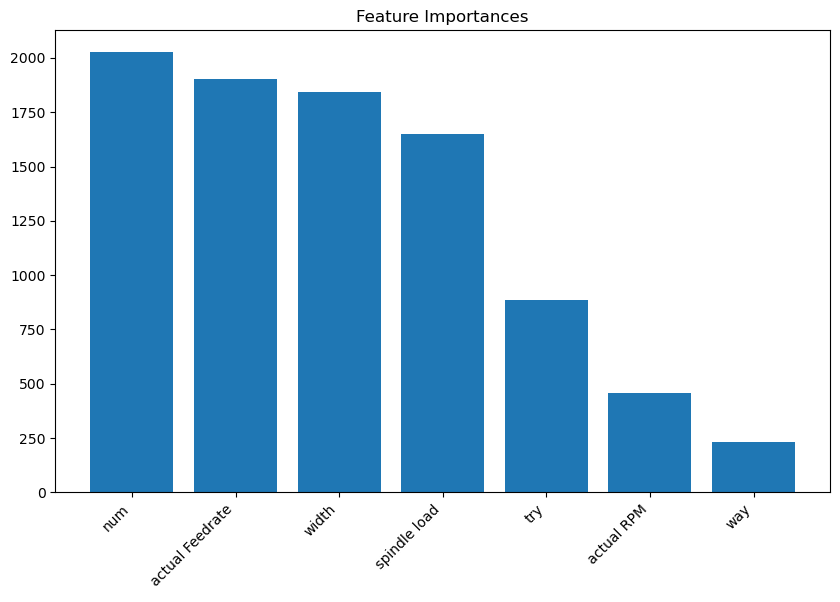

In [25]:
import matplotlib.pyplot as plt

# 변수 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'feature': features_col, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 막대 그래프 그리기
plt.figure(figsize=(10,6))
plt.bar(x=importance_df['feature'], height=importance_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances')
plt.show


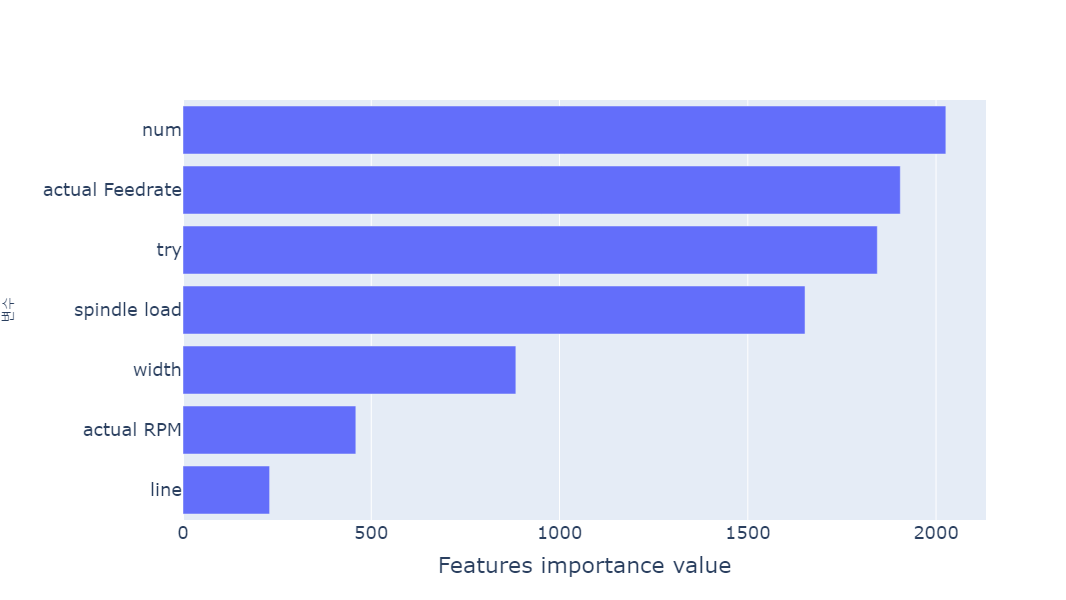

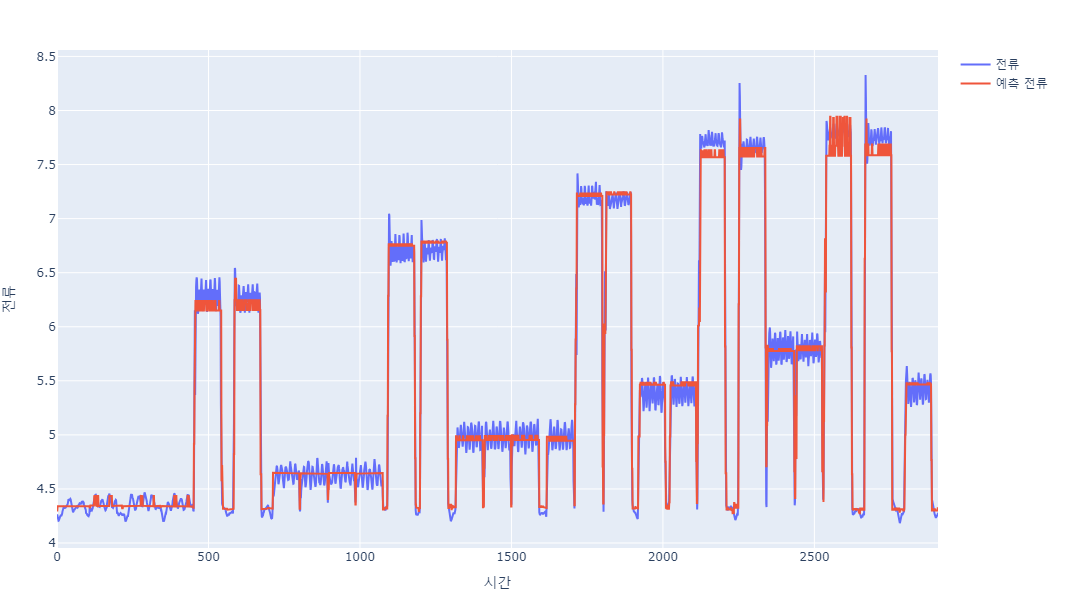

In [94]:
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio


feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, x_final_test[features_col].columns)),
                            columns=['Value', 'Feature'])

# 변수 중요도 시각화
fig1 = go.Figure(data=[go.Bar(x=feature_imp['Value'], y=feature_imp['Feature'],
                             textposition='auto', orientation='h')])


fig1.update_layout(
                   xaxis_title='Features importance value',
                   yaxis_title='변수',
                   yaxis=dict(
        title_font=dict(size=13)
    ),font=dict(
        size=18  # y축 범례 폰트 크기
    ))
                   
fig1.update_layout(
    width=800,
    height=600
)
pio.show(fig1)

# C1과 예측값 그래프 시각화
fig2 = sp.make_subplots(rows=1, cols=1)
fig2.add_trace(go.Scatter(y=visual_line[' C1'], name='전류'))
fig2.add_trace(go.Scatter(y=visual_line['preds'], name='예측 전류'))
fig2.update_layout(
                   xaxis_title='시간',
                  yaxis_title='전류')

fig2.update_layout(
    width=1200,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50),
)

fig2.update_layout(
    width=1500,
    height=600
)
pio.show(fig2)

# lgbm 베이지안

## 튜닝

In [ ]:

def lgbm_evaluate(colsample_bytree, min_split_gain, max_depth, min_child_weight, eta, subsample, reg_lambda):
  
  params = {'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'max_depth': int(max_depth),
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'learning_rate': eta,
            'reg_lambda': reg_lambda,
            'objective':'regression',
            'metric': 'rmse',
            'n_estimators' : 1000}
    
  lgbm = LGBMRegressor(**params, random_state = 42)
  
  # Cross Validation
  neg_mse_scores = cross_val_score(lgbm, X_train, Y_train,
                                    scoring = 'neg_mean_squared_error',
                                    cv = 3)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  mean_rmse = np.mean(rmse_scores)
  
  return -mean_rmse # BayesianOptimization의 maximize()를 사용하기 위해, RMSE 값을 음수로 반환

lgbm_bo = BayesianOptimization(lgbm_evaluate, {'colsample_bytree': (0.5, 1.0),
                                                'min_split_gain': (0, 10),
                                                'max_depth': (4, 9),
                                                'min_child_weight': (0, 5),
                                                'subsample':(0.3, 1.0),
                                                'eta': (0.01, 0.3),
                                                'reg_lambda': (0.1, 10)},
                                                random_state=0, allow_duplicate_points=True)
# 베이지안 최적화 결과 파라미터 최적값
lgbm_bo.maximize(init_points=5, n_iter=100, acq='ei')


# 평가데이터 셋 설정 
evals =[(X_train, Y_train), (X_valid, Y_valid)]


# 파라미터 최적값 을 모델에 할당
model_bopt = LGBMRegressor(colsample_bytree = lgbm_bo.max['params']['colsample_bytree'],
                    min_split_gain = lgbm_bo.max['params']['min_split_gain'],
                    max_depth = int(lgbm_bo.max['params']['max_depth']),
                    min_child_weight = lgbm_bo.max['params']['min_child_weight'],
                    subsample = lgbm_bo.max['params']['subsample'],
                    learning_rate = lgbm_bo.max['params']['eta'],
                    reg_lambda = lgbm_bo.max['params']['reg_lambda'],
                    objective = 'regression',
                    metric = 'rmse',
                    n_estimators = 200, random_state = 0)

# 학습 
model_bopt.fit(X_train, Y_train, early_stopping_rounds = 30, eval_set=evals,  verbose=0)

In [182]:
## 예측
m_preds= model_bopt.predict(X_test)

## 성능 평가
print('R2 : ', model_bopt.score(X_test,Y_test)) ## 테스트 성능 평가 점수(Accuracy)

rmse = np.sqrt(mean_squared_error(m_preds, Y_test))
print("RMSE: %f" % (rmse))
## 변수 중요도
for l, feature in enumerate(X_test[features_col].columns):
    print(f'{feature} : {model_bopt.feature_importances_[l]}')
print(' 튜닝 후 \n')

R2 :  0.9801367435385311
RMSE: 0.193500
F : 1105
ω : 284
f : 1180
w : 1372
n : 740
d : 157
m : 1162
 튜닝 후 



# 예측 결과 시각화

## 전류

In [122]:
tt = pd.read_csv('C:/Users/default.DESKTOP-VR7UF4O/Desktop/CNC/진짜 다시는 손안대는 원본데이터/vis_test3_feed100_2.csv', index_col=0)
tt.drop(' AdaptiveOn',axis = 1, inplace =True)
tt

,spindle load,actual RPM,actual Feedrate,C1,width,try,line,num
59,0,3999,467,4.2607,3.200,2,0,1.0
60,0,3999,467,4.2591,3.200,2,0,1.0
61,0,3999,1000,4.2466,3.200,2,0,1.0
62,0,3999,1000,4.2341,3.200,2,0,1.0
63,0,4000,1000,4.2248,3.200,2,0,1.0
...,...,...,...,...,...,...,...,...
2963,0,4000,1000,4.2466,2.601,2,0,27.0
2964,0,4000,1000,4.2529,2.601,2,0,27.0
2965,0,4000,1000,4.2591,2.601,2,0,27.0
2966,0,3999,716,4.2685,2.601,2,0,27.0


In [123]:
# x,y 분리
x_final_test = tt.drop(' C1',axis = 1)
y_final_test = tt[' C1']

# 정규화 
x_final_test[ : ] = scaler.transform(x_final_test[ : ]) # 정규화

#데이터 프레임화 
x_final_test=pd.DataFrame(x_final_test)
y_final_test=pd.DataFrame(y_final_test)


In [124]:
## model_bopt 시각화용 데이터 예측
preds = model_bopt.predict(x_final_test)

##  model_bopt 성능 평가
print('model_bopt R2 : ', model_bopt.score(x_final_test,y_final_test)) ## 테스트 성능 평가 점수(Accuracy)

rmse = np.sqrt(mean_squared_error(preds, y_final_test))
print("model_bopt RMSE: %f" % (rmse))

## model_bopt 변수 중요도
for l, feature in enumerate(x_final_test[features_col].columns):
    print(f'{feature} : {model_bopt.feature_importances_[l]}')
print(' 튜닝 후 \n')

model_bopt R2 :  0.9825329586638702
model_bopt RMSE: 0.157240
 spindle load : 1105
 actual RPM : 284
 actual Feedrate : 1180
try : 1372
width : 740
line : 157
num : 1162
 튜닝 후 



In [125]:
# 결과 시각화용 y_test, preds 값  데이터 프레임 생성
preds = pd.DataFrame(preds)

y_final_test.reset_index(inplace = True)

y_final_test= y_final_test.drop('index', axis =1)

visual_line =pd.concat([preds, y_final_test],axis = 1)

visual_line.rename(columns={0:'preds'}, inplace= True)

In [148]:
visual_line.to_csv('visual_pred.csv')

In [67]:
visual_line= pd.read_csv('C:\\Users\\USER\\Desktop\\논문작성용 데이터및 모델\\논문작성용 데이터및 모델\\visual_pred.csv', index_col=0)

visual_line['time']=np.linspace(15,290,2909)

visual_line

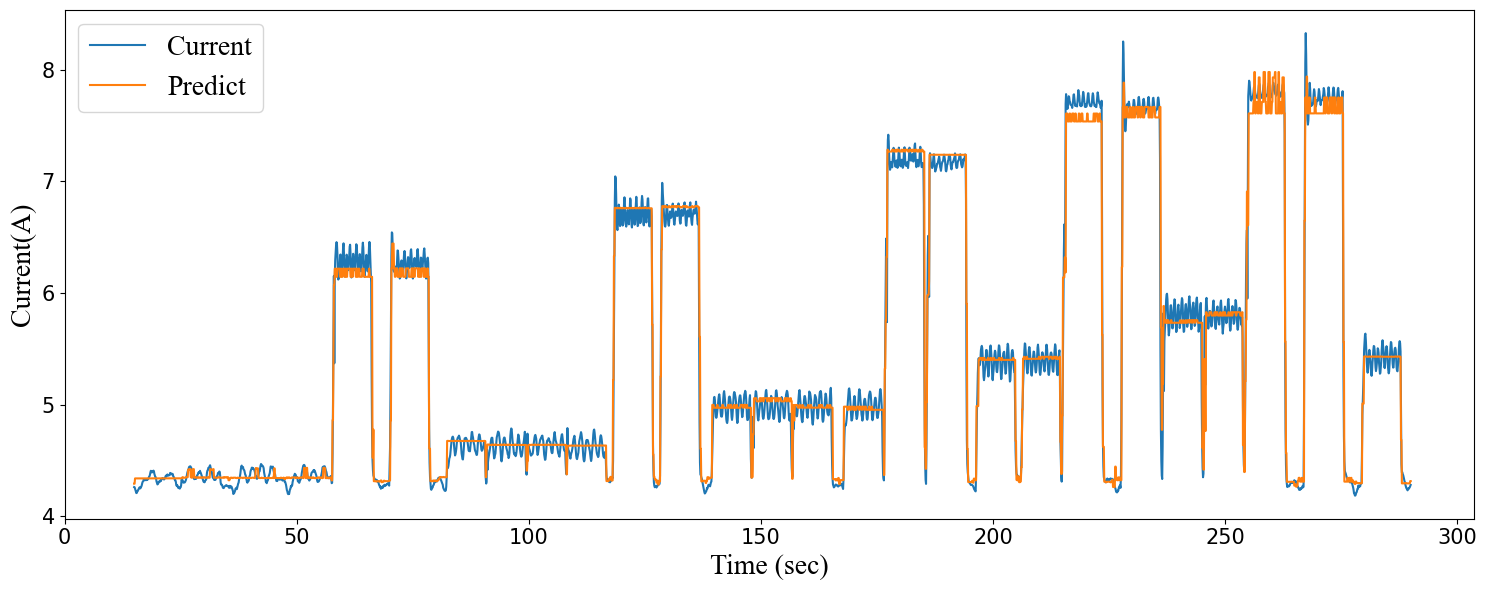

In [187]:


# C1과 예측값 그래프 시각화
fig2, ax2 = plt.subplots(figsize=(15, 6))
x = np.arange(len(visual_line))
ax2.plot(visual_line['time'], visual_line[' C1'], label='Current')
ax2.plot(visual_line['time'], visual_line['preds'], label='Predict')
ax2.legend(loc='upper left', prop={'family':'Times New Roman', 'size':20})

xticks = [0,50,100,150,200,250,300]

ax2.set_xticks(xticks)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Time (sec)', size=20, font ='Times New Roman')
ax2.set_ylabel('Current(A)', size=20, font ='Times New Roman')
ax2.grid(axis='y', linestyle='', alpha=0.7)
fig2.tight_layout()
plt.show()

In [179]:
# 변수 중요도 데이터프레임 생성

importance_df = pd.DataFrame({'feature': features_col, 'importance': model_bopt.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)

In [226]:
importance_df

,feature,importance
5,d,157
1,ω,284
4,n,740
0,F,1105
6,m,1162
2,f,1180
3,w,1372


<function matplotlib.pyplot.show(close=None, block=None)>

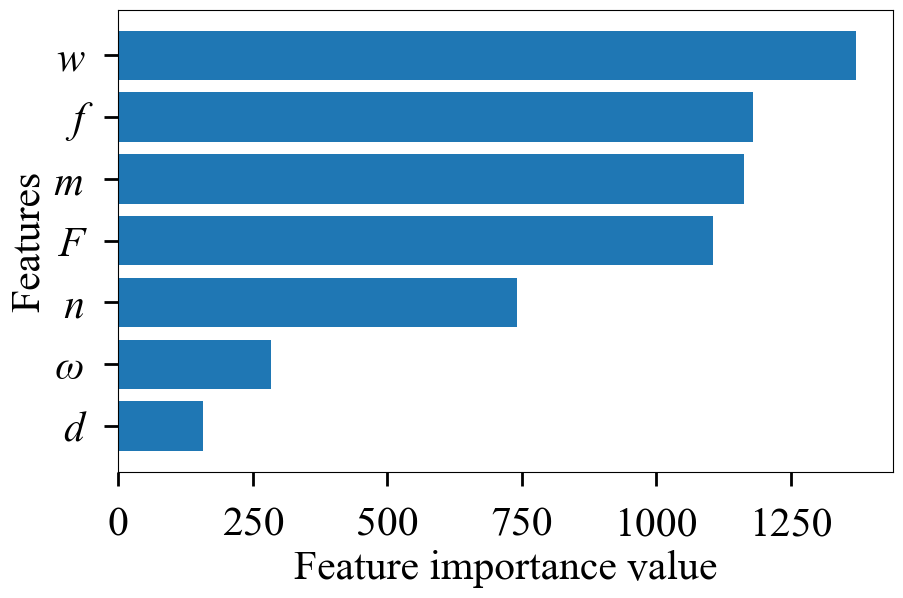

In [225]:
# 변수 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'feature': features_col, 'importance': model_bopt.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=True)

# 막대 그래프 그리기
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature importance value', fontsize=30, font='Times New Roman')
plt.ylabel('Features', fontsize=30, font='Times New Roman')
plt.xticks(font='Times New Roman')
plt.yticks(font='Times New Roman', fontstyle='italic')
plt.tick_params(axis='x', direction='out', length=10, pad=15, labelsize=30,  width=2)
plt.tick_params(axis='y', direction='out', length=10, pad=15, labelsize=30, width=2)
plt.show
